In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import os
import pickle
from PIL import Image
import random
import warnings
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Accuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [8]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# Reading dataset as dataframe

df_img = pd.read_csv('./../data/cleaned/ferplus.csv')
df_img.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_2296,Pixel_2297,Pixel_2298,Pixel_2299,Pixel_2300,Pixel_2301,Pixel_2302,Pixel_2303,Pixel_2304,Label
0,30,24,21,23,25,25,49,67,84,103,...,106,111,148,137,176,174,172,173,173,anger
1,123,125,124,142,209,226,234,236,231,232,...,103,116,111,105,105,103,97,91,89,anger
2,236,230,225,226,228,209,199,193,196,211,...,192,190,186,171,144,144,152,155,173,anger
3,255,82,0,3,0,0,0,0,0,0,...,101,217,255,198,143,236,254,254,254,anger
4,206,208,209,212,214,216,216,219,221,222,...,38,42,50,47,26,31,29,40,5,anger


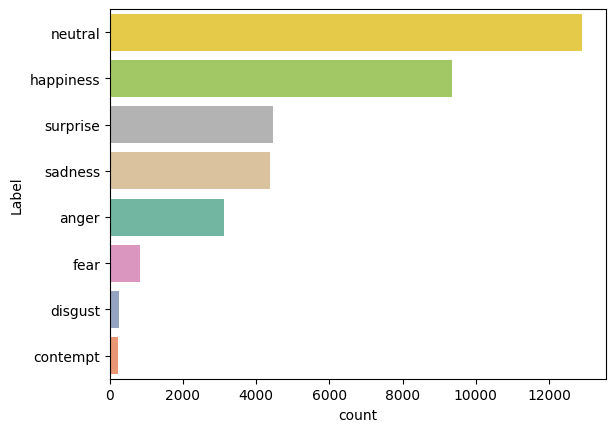

In [10]:
# Checking how many images we have for each label

counts = df_img['Label'].value_counts().sort_values(ascending=False)

sns.countplot(y=df_img['Label'], hue=df_img['Label'], order=counts.index, palette='Set2')
plt.show()

In [11]:
df_img = df_img[~df_img['Label'].isin(['contempt', 'disgust'])]
df_img['Label'].unique()

array(['anger', 'fear', 'happiness', 'neutral', 'sadness', 'surprise'],
      dtype=object)

In [12]:
def normalize(value):
    return value/255

pixel_cols = [col for col in df_img.columns if 'Pixel' in col]

for col in pixel_cols:
    df_img[col].astype(float)

df_img.iloc[:, :-1] = df_img.iloc[:, :-1].apply(normalize)

df_img.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_2296,Pixel_2297,Pixel_2298,Pixel_2299,Pixel_2300,Pixel_2301,Pixel_2302,Pixel_2303,Pixel_2304,Label
0,0.117647,0.094118,0.082353,0.090196,0.098039,0.098039,0.192157,0.262745,0.329412,0.403922,...,0.415686,0.435294,0.580392,0.537255,0.690196,0.682353,0.674510,0.678431,0.678431,anger
1,0.482353,0.490196,0.486275,0.556863,0.819608,0.886275,0.917647,0.925490,0.905882,0.909804,...,0.403922,0.454902,0.435294,0.411765,0.411765,0.403922,0.380392,0.356863,0.349020,anger
2,0.925490,0.901961,0.882353,0.886275,0.894118,0.819608,0.780392,0.756863,0.768627,0.827451,...,0.752941,0.745098,0.729412,0.670588,0.564706,0.564706,0.596078,0.607843,0.678431,anger
3,1.000000,0.321569,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.396078,0.850980,1.000000,0.776471,0.560784,0.925490,0.996078,0.996078,0.996078,anger
4,0.807843,0.815686,0.819608,0.831373,0.839216,0.847059,0.847059,0.858824,0.866667,0.870588,...,0.149020,0.164706,0.196078,0.184314,0.101961,0.121569,0.113725,0.156863,0.019608,anger


In [13]:
labels = df_img['Label'].unique().tolist()

mapping_dict = dict(zip(labels, range(8)))

df_img['Label'] = df_img['Label'].replace(mapping_dict)

df_img['Label'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [14]:
# Splitting dataset into X and y

X = df_img.drop(columns='Label')
y = df_img['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

X_train_np = np.array(X_train).reshape((-1, 48, 48, 1))
y_train_np = np.array(y_train)
X_test_np = np.array(X_test).reshape((-1, 48, 48, 1))
y_test_np = np.array(y_test)

# Assuming y_train contains the class labels for your training data
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weights_dict = dict(enumerate(class_weights))

In [15]:
# Initializing model
model = Sequential()

# Conv layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flattening + dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

Epoch 1/20
701/701 - 27s - loss: 1.3236 - accuracy: 0.5094 - val_loss: 1.0992 - val_accuracy: 0.5992 - lr: 0.0010 - 27s/epoch - 39ms/step
Epoch 2/20
701/701 - 3s - loss: 0.9849 - accuracy: 0.6392 - val_loss: 0.9303 - val_accuracy: 0.6592 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 3/20
701/701 - 3s - loss: 0.8479 - accuracy: 0.6883 - val_loss: 0.8623 - val_accuracy: 0.6768 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 4/20
701/701 - 3s - loss: 0.7619 - accuracy: 0.7173 - val_loss: 0.8202 - val_accuracy: 0.6924 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 5/20
701/701 - 3s - loss: 0.6885 - accuracy: 0.7466 - val_loss: 0.8227 - val_accuracy: 0.6945 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 6/20
701/701 - 3s - loss: 0.6313 - accuracy: 0.7666 - val_loss: 0.7860 - val_accuracy: 0.7186 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 7/20
701/701 - 3s - loss: 0.5669 - accuracy: 0.7910 - val_loss: 0.7979 - val_accuracy: 0.7186 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 8/20
701/701 - 3s - loss: 0.5136 - accuracy: 0

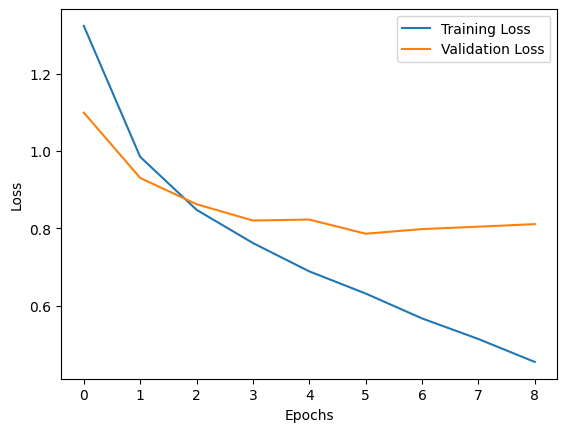

In [16]:
model_path = './../models/best_custom_model.h5'

callbacks = [EarlyStopping(patience=3, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=4, verbose=1),
             ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy')]

# Fitting

history = model.fit(X_train_np, y_train_np, epochs=20, batch_size=32, validation_split=0.2, verbose=2, callbacks=callbacks)

# Plotting train and val losses

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

219/219 [==============================] - 0s 2ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.65      0.57      0.61       709
           1       0.26      0.59      0.36        73
           2       0.83      0.81      0.82      1914
           3       0.81      0.74      0.78      2840
           4       0.35      0.61      0.44       505
           5       0.80      0.74      0.77       964

    accuracy                           0.73      7005
   macro avg       0.62      0.68      0.63      7005
weighted avg       0.76      0.73      0.74      7005

Cohen-Kappa score: 0.6359309530605666


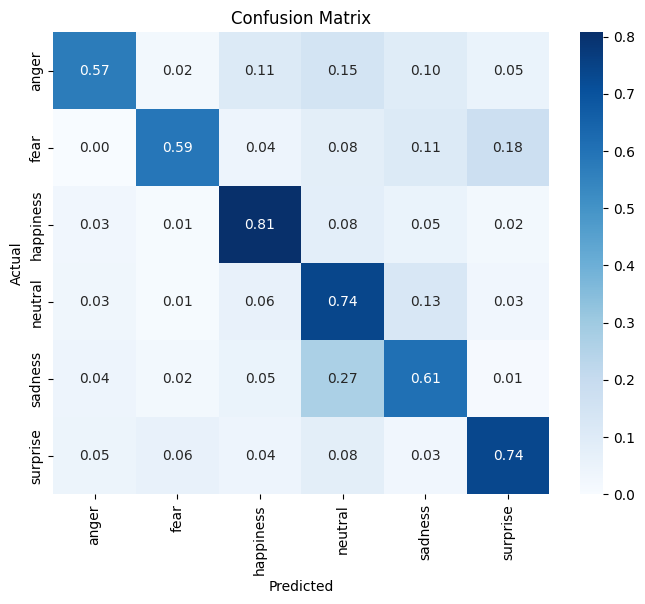

In [17]:
# Performance metrics on test set

y_pred_proba = model.predict(X_test_np)

y_pred = [np.argmax(x) for x in y_pred_proba]

cr = classification_report(y_pred, y_test)
print(f'Classification report:\n{cr}')

chs = cohen_kappa_score(y_pred, y_test)
print(f'Cohen-Kappa score: {chs}')

cm = confusion_matrix(y_pred, y_test, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()